# Notebook to create pixel grid based on Sentinel 2 images from drone passes

In [27]:
%matplotlib inline
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import xarray as xr

from scipy import ndimage

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../../Scripts'))
from dea_datahandling import load_ard
from dea_plotting import rgb

# Connect to datacube
dc = Datacube(app='Sentinel2 pixelgrid')

%load_ext autoreload
%autoreload 2

In [51]:
# Create a reusable query
query = {
    #-27.521489, 153.463994 -27.556528, 153.507053
    'x': (153.46, 153.51),
    'y': (-27.51, -27.55),
    'time': ('2019-07', '2019-10'),
    'measurements': ['nbart_blue', 'nbart_green','nbart_red', 'nbart_nir_1','nbart_swir_2','nbart_swir_3'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

In [52]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              min_gooddata=1,
              **query)

Loading s2a_ard_granule data
    Filtering to 2 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 3 out of 13 observations
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 5 observations 


In [53]:
ds

<xarray.Dataset>
Dimensions:       (time: 5, x: 187, y: 175)
Coordinates:
  * y             (y) float64 -3.16e+06 -3.16e+06 ... -3.165e+06 -3.165e+06
  * x             (x) float64 2.084e+06 2.084e+06 ... 2.089e+06 2.089e+06
  * time          (time) datetime64[ns] 2019-07-10T23:52:51.024000 ... 2019-09-13T23:52:49.024000
Data variables:
    nbart_blue    (time, y, x) float32 218.0 193.0 208.0 ... 314.0 307.0 340.0
    nbart_green   (time, y, x) float32 297.0 267.0 367.0 ... 215.0 221.0 230.0
    nbart_red     (time, y, x) float32 261.0 267.0 300.0 ... 141.0 136.0 139.0
    nbart_nir_1   (time, y, x) float32 2187.0 2029.0 2354.0 ... 115.0 130.0
    nbart_swir_2  (time, y, x) float32 1193.0 1192.0 1153.0 ... 55.0 61.0 56.0
    nbart_swir_3  (time, y, x) float32 566.0 549.0 539.0 ... 34.0 40.0 39.0
Attributes:
    crs:      EPSG:3577

In [56]:
#rgb(ds, bands = ['nbart_swir_2','nbart_nir_1','nbart_green'],col='time')

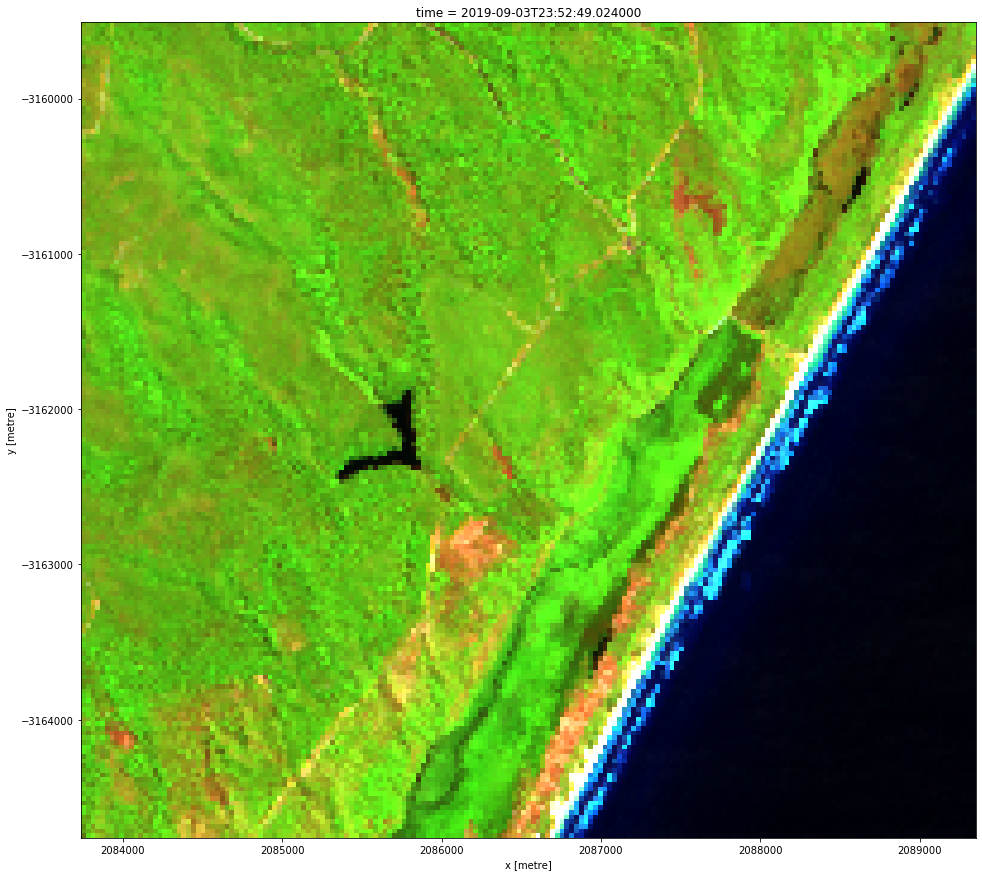

In [57]:
rgb(ds, bands = ['nbart_swir_2','nbart_nir_1','nbart_green'],index=3, size=15)

In [66]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

In [67]:
ds.nbart_blue

<xarray.DataArray 'nbart_blue' (time: 5, y: 175, x: 187)>
array([[[218., 193., ..., 365., 253.],
        [231., 235., ..., 282., 251.],
        ...,
        [170., 190., ..., 204., 191.],
        [173., 293., ..., 188., 206.]],

       [[182., 165., ..., 349., 239.],
        [201., 214., ..., 290., 277.],
        ...,
        [199., 227., ..., 255., 274.],
        [201., 338., ..., 254., 273.]],

       ...,

       [[206., 233., ..., 383., 291.],
        [241., 237., ..., 306., 283.],
        ...,
        [231., 269., ..., 267., 232.],
        [209., 290., ..., 223., 249.]],

       [[299., 318., ..., 460., 402.],
        [296., 322., ..., 418., 383.],
        ...,
        [354., 389., ..., 319., 321.],
        [358., 403., ..., 307., 340.]]], dtype=float32)
Coordinates:
  * y        (y) float64 -3.16e+06 -3.16e+06 -3.16e+06 ... -3.165e+06 -3.165e+06
  * x        (x) float64 2.084e+06 2.084e+06 2.084e+06 ... 2.089e+06 2.089e+06
  * time     (time) datetime64[ns] 2019-07-10T23:52:51.02

In [70]:
image.max()

255.0

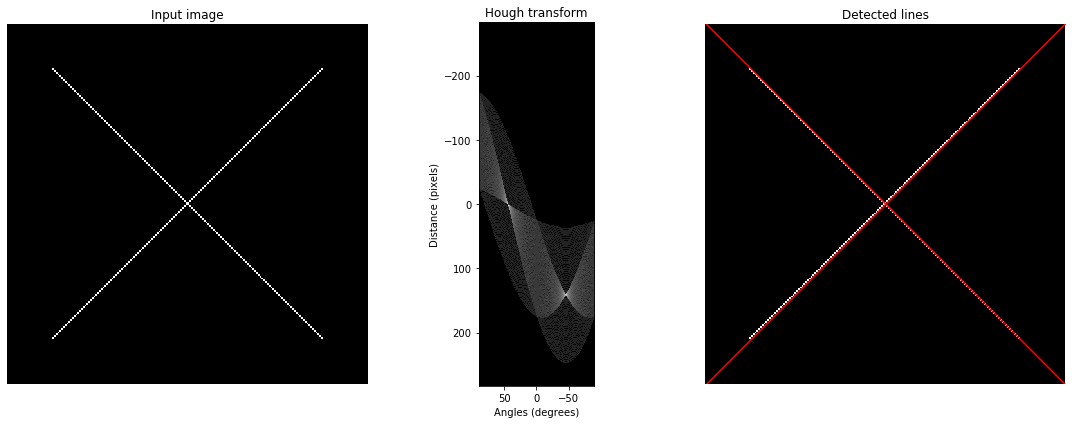

In [62]:
# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()